# Functional API

In [1]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

In [3]:
ds = image_dataset_from_directory('/home/jupyter/data_local', label_mode=None, image_size=(448, 448), batch_size=16)

Found 2360 files belonging to 1 classes.


2023-03-09 11:54:56.246074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 11:54:56.259125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 11:54:56.260932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 11:54:56.264660: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
##ds = ds.map(lambda x: x/255)
##ds = ds.map(lambda x: (x, x))

In [4]:
imgs = ds.as_numpy_iterator().__next__()

In [5]:
imgs.shape

(16, 448, 448, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


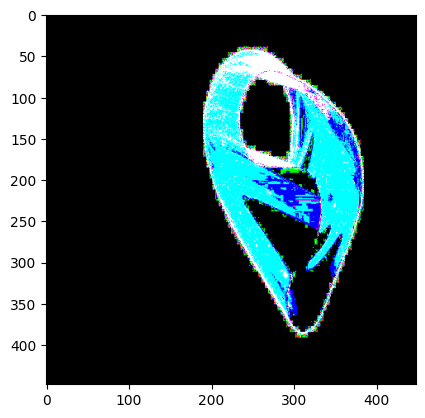

In [6]:
plt.imshow(imgs[0])

In [35]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras import Model

X_train=imgs/255


def build_encoder(latent_dimension):
    
    input_image = Input(shape=(448, 448, 3))
    
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_image)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(256, (3, 3), padding='same', activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    encoder_output = Dense(latent_dimension, activation='tanh')(x)
    
    encoder = Model(inputs=input_image, outputs=encoder_output)

    return encoder




In [36]:
# def sampling(args):
#     z_mu, z_log_sigma = args
#     epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
#                               mean=0., stddev=1.)
#     return z_mu + K.exp(z_log_sigma) * epsilon

In [37]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling2D


def build_decoder(latent_dimension):
    
    latent_space_input = Input(shape=(latent_dimension,))
    
    x = Dense(7*7*64, activation='tanh')(latent_space_input)
    x = Reshape((7, 7, 64))(x)
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation='relu')(x)
    
    decoder_output = Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid')(x)
    
    decoder = Model(inputs=latent_space_input, outputs=decoder_output)
    
    return decoder

In [38]:
# from keras.models import Model
# from keras.losses import binary_crossentropy

In [26]:
encoder = build_encoder(latent_dimension=800)


In [27]:
decoder = build_decoder(latent_dimension=800)

In [28]:
encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 448, 448, 32)      896       
                                                                 
 batch_normalization_20 (Bat  (None, 448, 448, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 224, 224, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 224, 224, 64)      18496     
                                                                 
 batch_normalization_21 (Bat  (None, 224, 224, 64)     256 

In [29]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 3136)              2511936   
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 128)      73856     
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 56, 56, 32)       18464     
 ranspose)                                                       
                                                      

In [30]:

def build_autoencoder(encoder, decoder):
    inp = Input((448, 448, 3))
    encoded = encoder(inp)
    decoded = decoder(encoded)
    autoencoder = Model(inp, decoded)
    return autoencoder

autoencoder = build_autoencoder(encoder, decoder)

In [31]:
def compile_autoencoder(autoencoder):
    autoencoder.compile(loss='mse', optimizer='adam')

In [33]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

compile_autoencoder(autoencoder)
autoencoder.fit(X_train, X_train, epochs=1000, batch_size=32, callbacks=[es], verbose=1)


Epoch 1/1000


2023-03-09 12:21:00.692141: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


1/1 [==============================] - 7s 7s/step - loss: 0.2378
Epoch 2/1000
1/1 [==============================] - 1s 685ms/step - loss: 0.2375
Epoch 3/1000
1/1 [==============================] - 1s 688ms/step - loss: 0.2372
Epoch 4/1000
1/1 [==============================] - 1s 700ms/step - loss: 0.2369
Epoch 5/1000
1/1 [==============================] - 1s 687ms/step - loss: 0.2367
Epoch 6/1000
1/1 [==============================] - 1s 686ms/step - loss: 0.2364
Epoch 7/1000
1/1 [==============================] - 1s 681ms/step - loss: 0.2362
Epoch 8/1000
1/1 [==============================] - 1s 686ms/step - loss: 0.2359
Epoch 9/1000
1/1 [==============================] - 1s 689ms/step - loss: 0.2357
Epoch 10/1000
1/1 [==============================] - 1s 685ms/step - loss: 0.2354
Epoch 11/1000
1/1 [==============================] - 1s 687ms/step - loss: 0.2351
Epoch 12/1000
1/1 [==============================] - 1s 689ms/step - loss: 0.2349
Epoch 13/1000
1/1 [======================

In [39]:
prediction = autoencoder.predict(X_train, verbose=0, batch_size=32)# you can now display an image to see it is reconstructed well
    

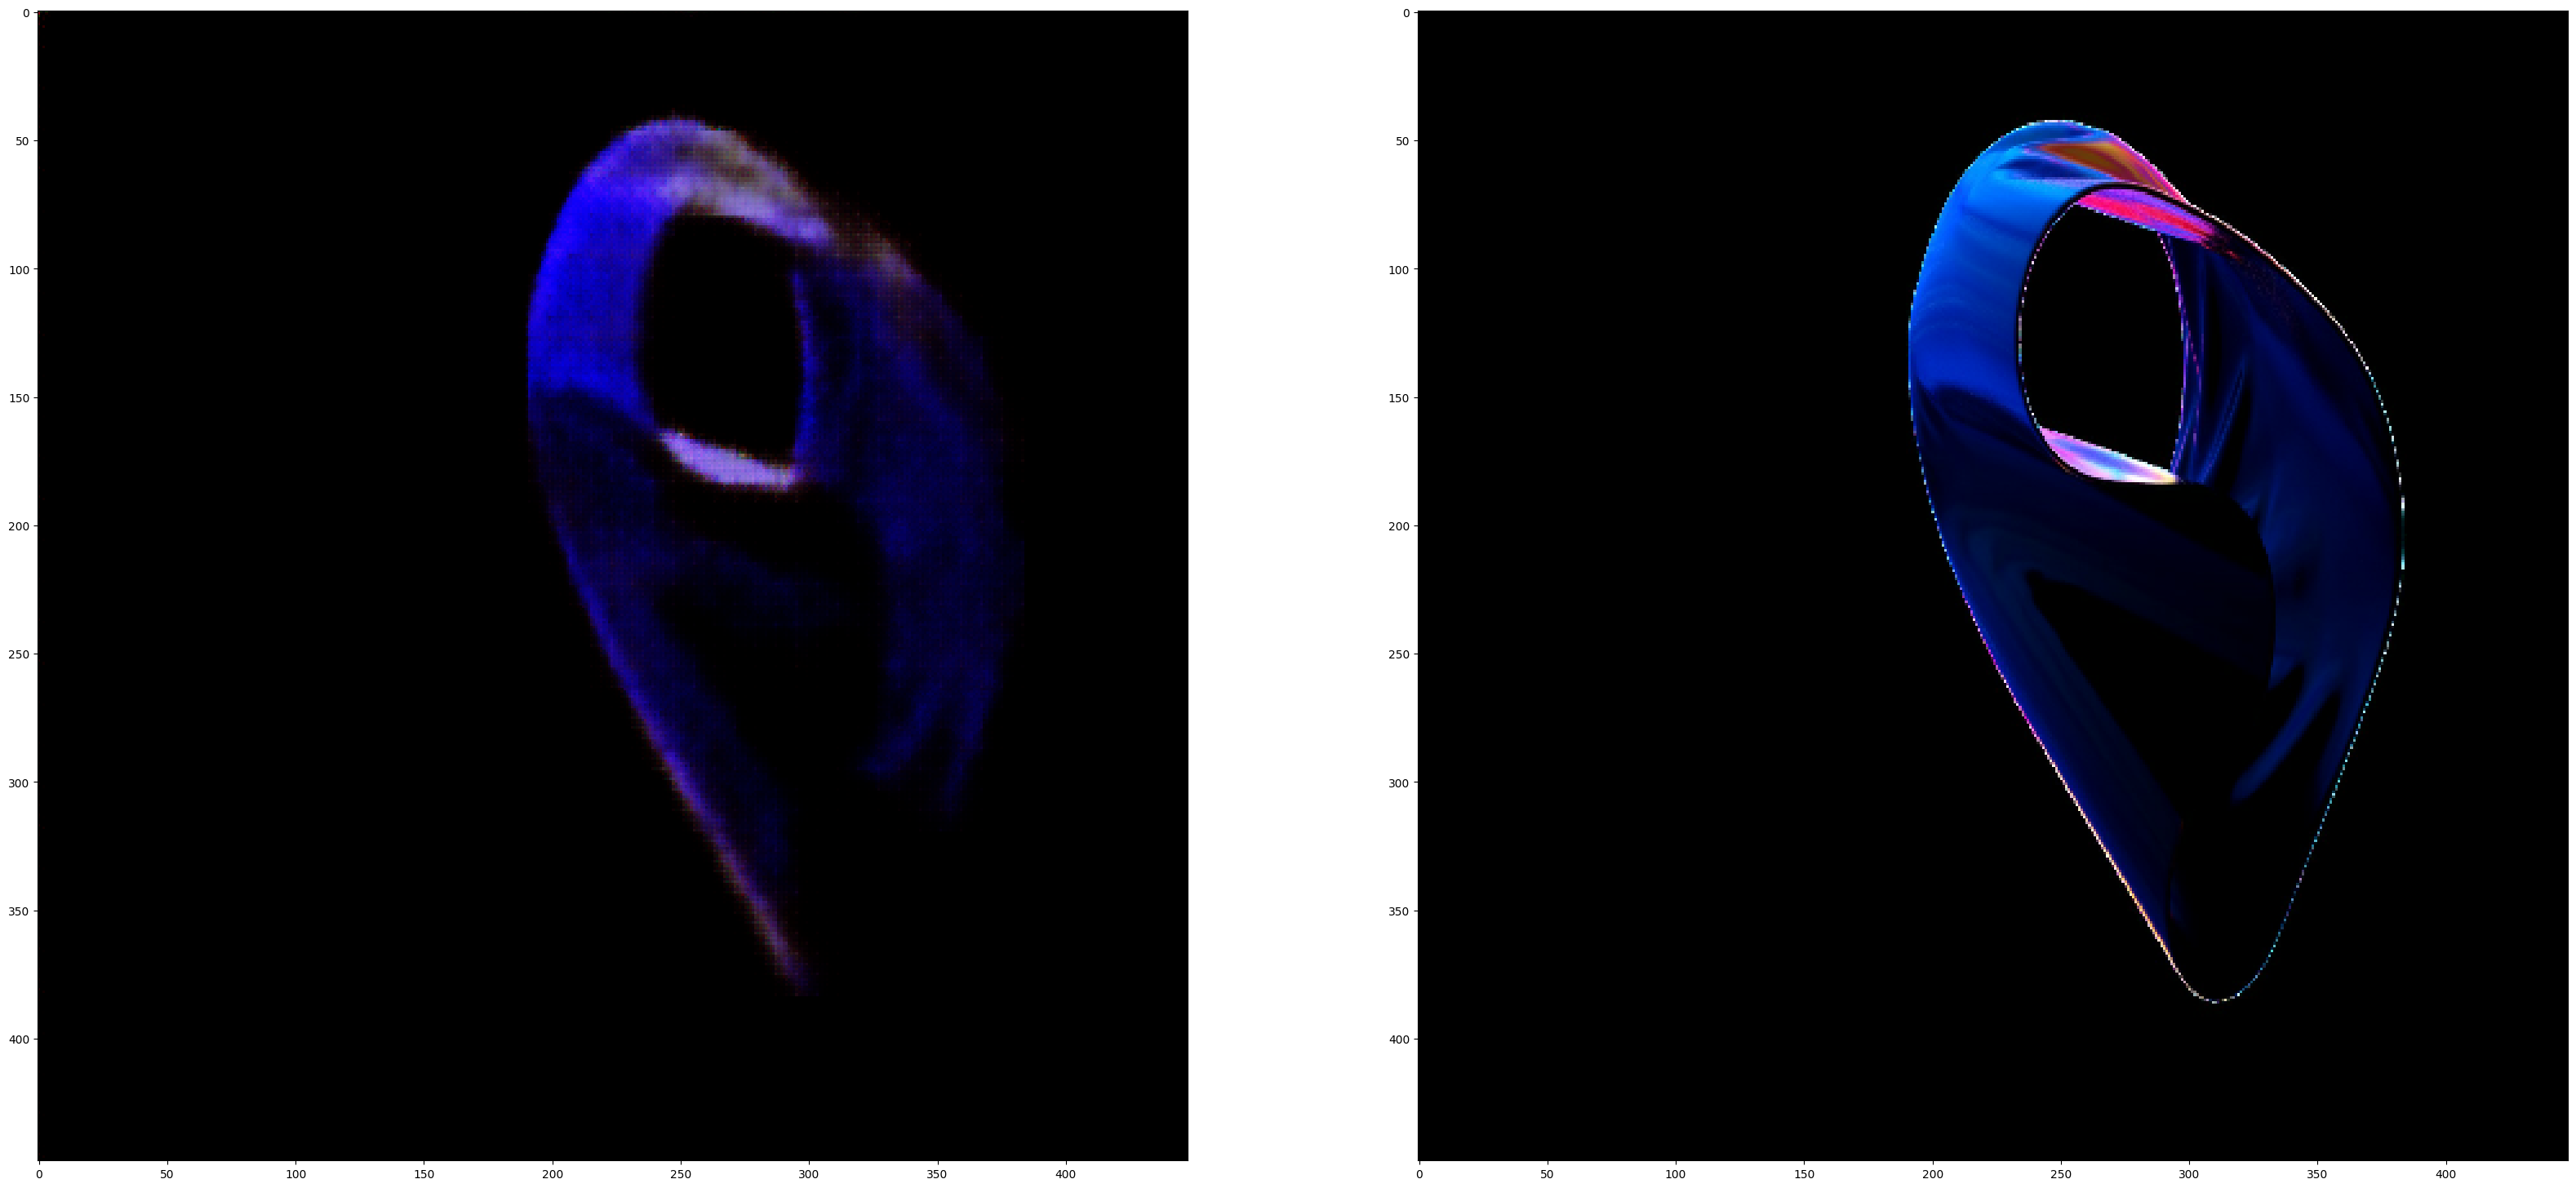

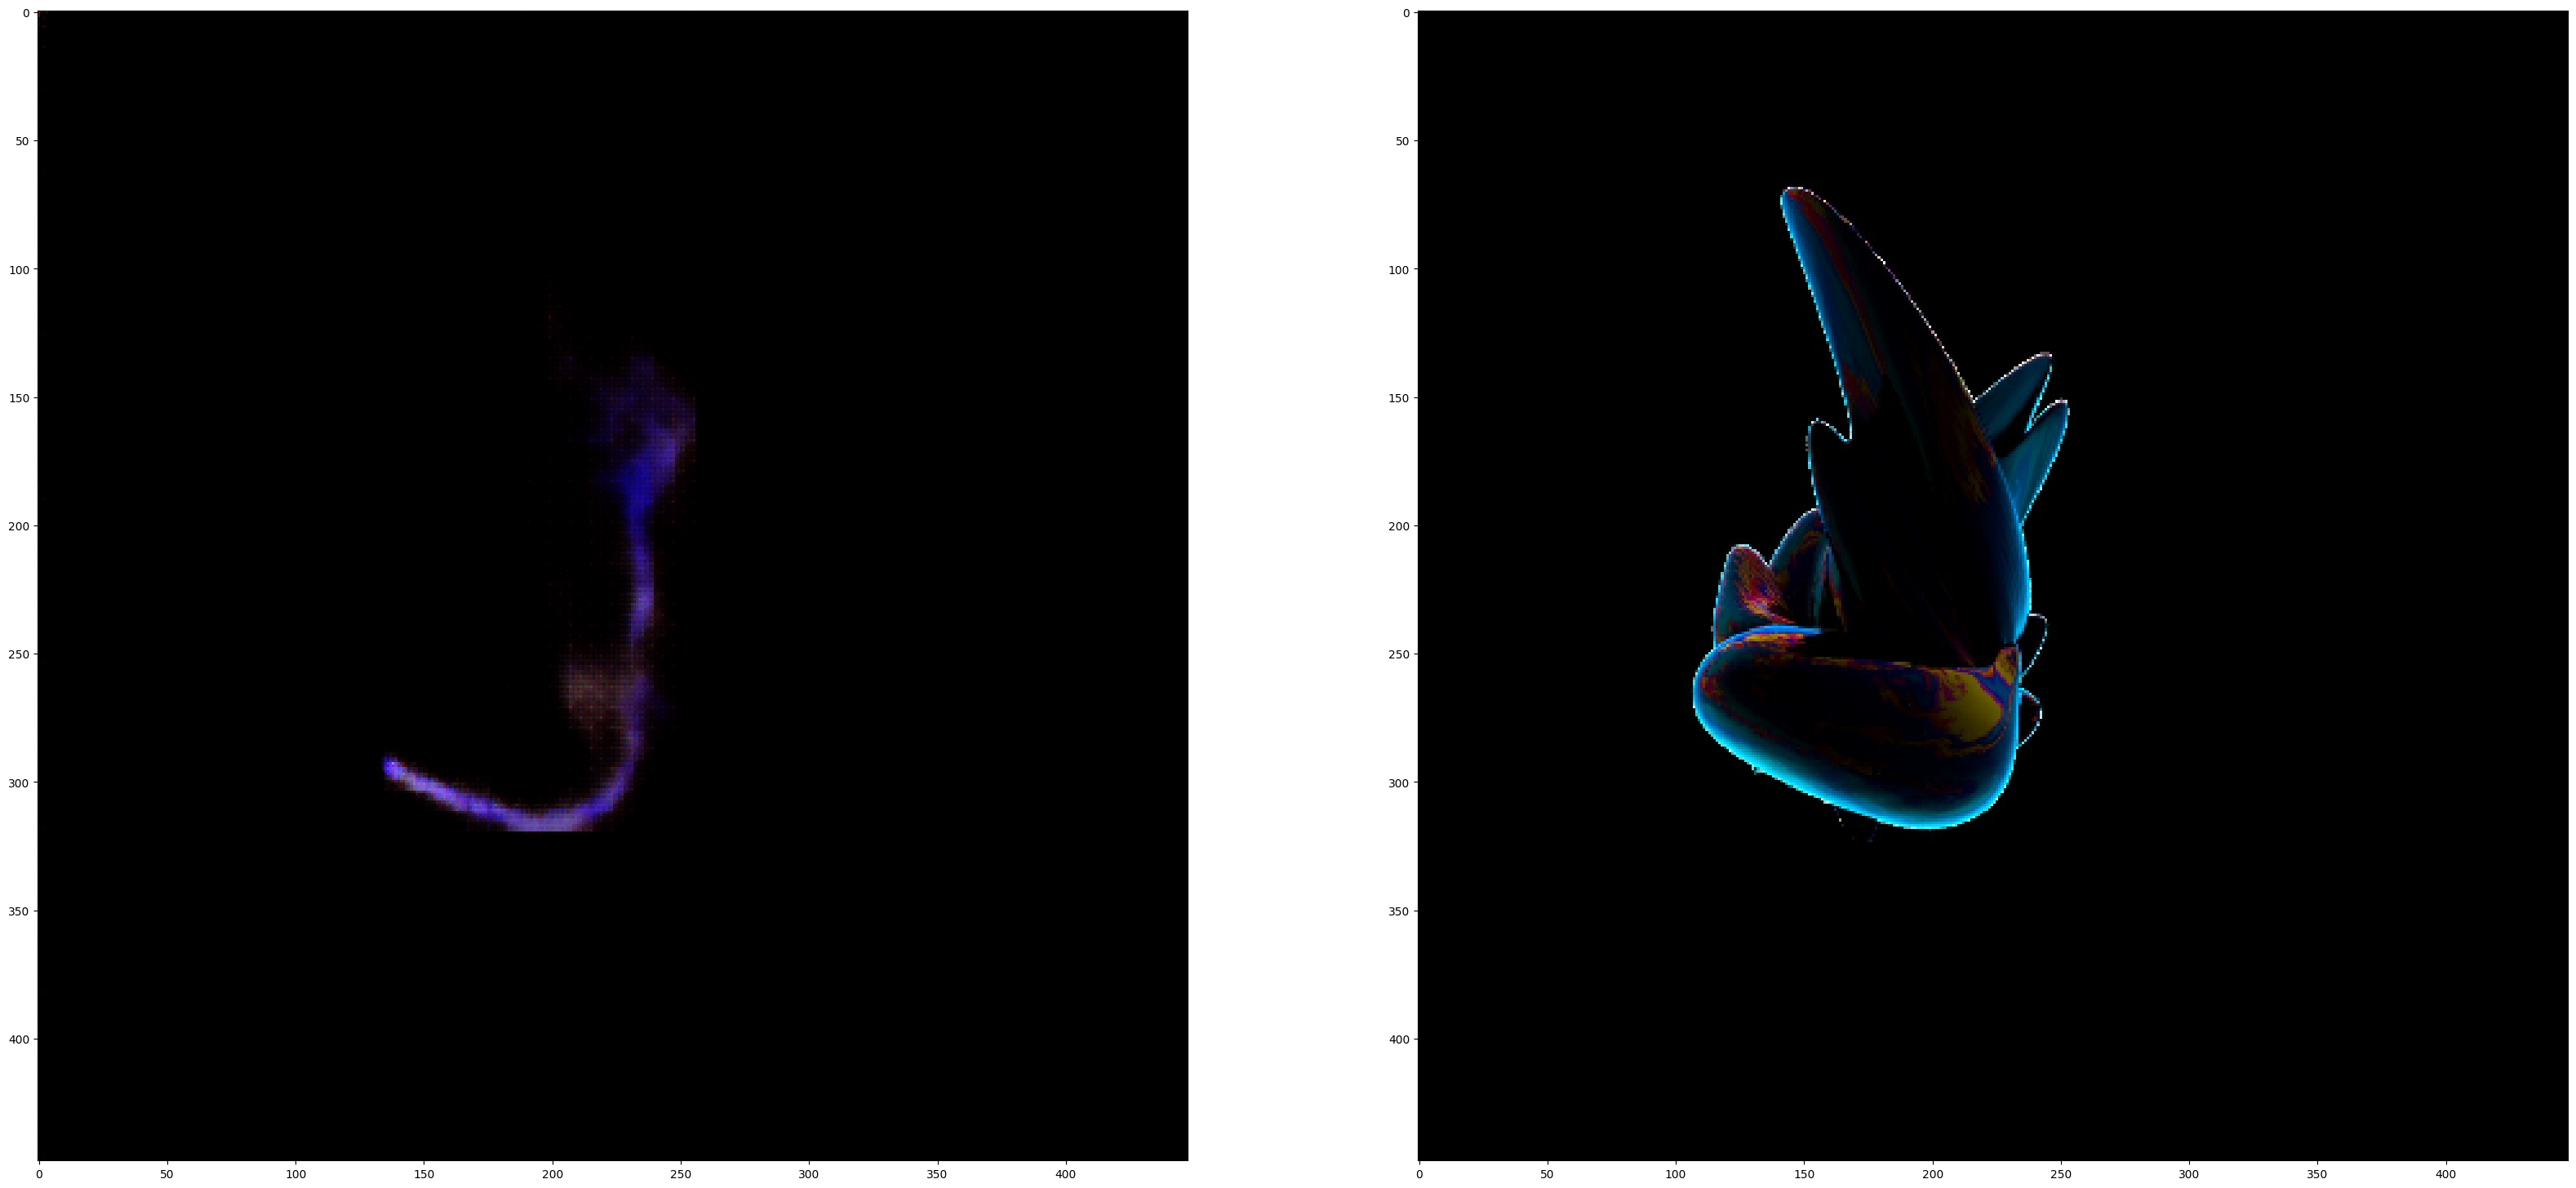

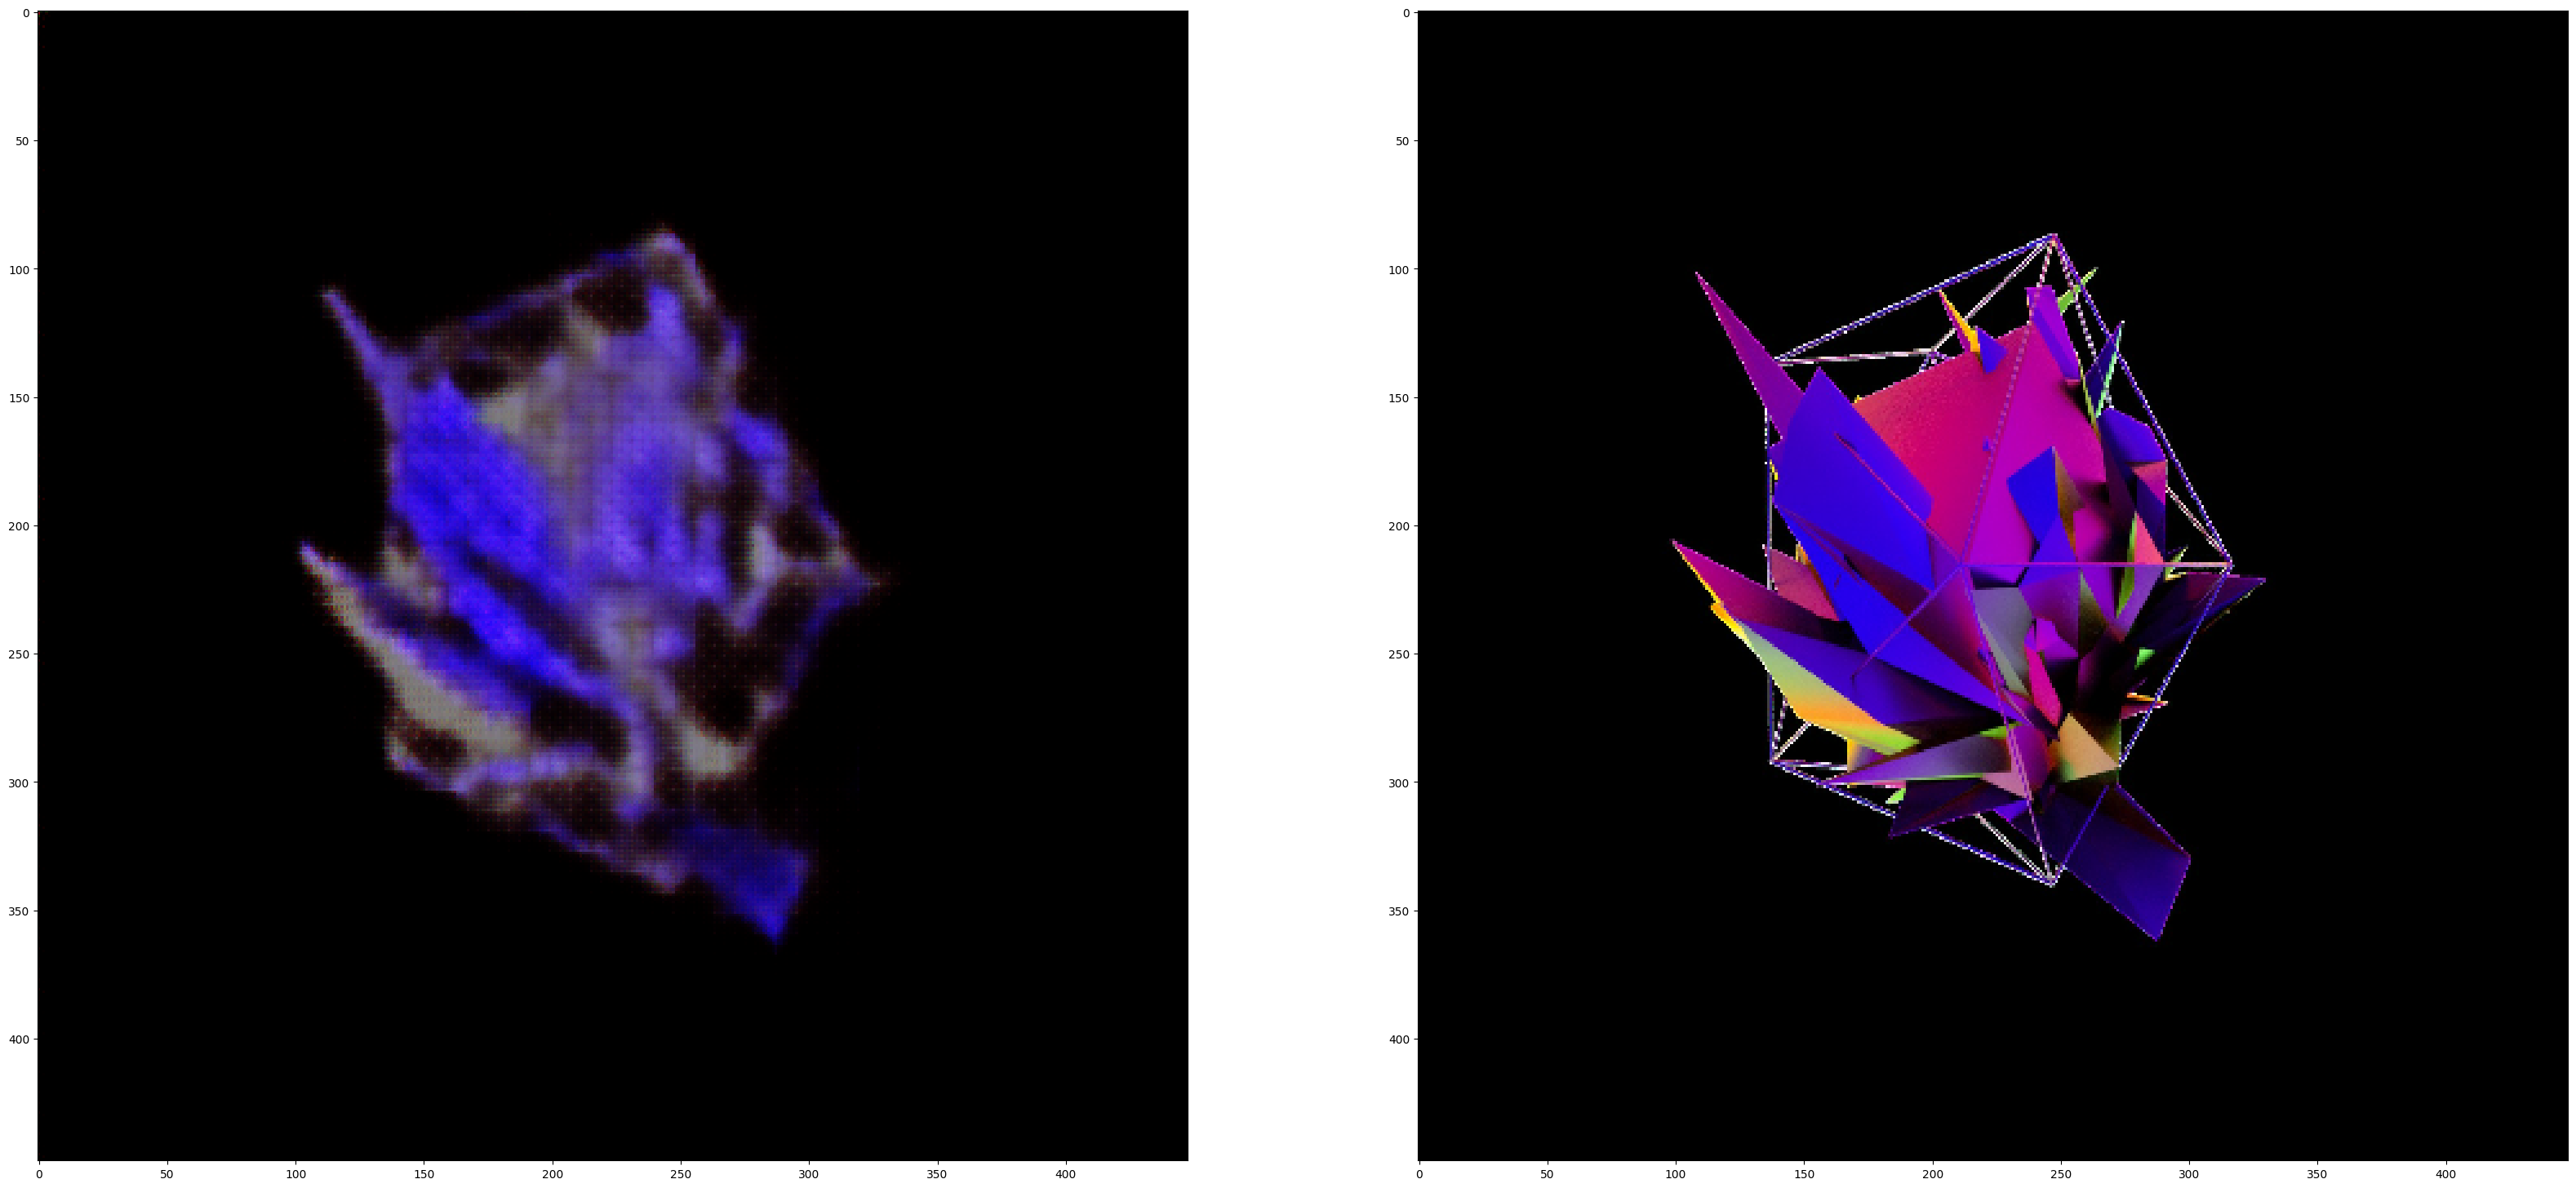

In [40]:
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
    ax1.imshow((prediction[i] * 255).astype(np.uint8))
    ax2.imshow(X_train[i].reshape(448, 448, 3))
    plt.show()

In [34]:
#autoencoder.save('autoencoder-latent-dim-800.h5')

In [4]:
# !pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 20.0 MB/s eta 0:00:0000:0100:01


In [5]:
import cv2
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter('video.mp4', fourcc, 25.0, (448, 448))

for i in range(len(prediction)):
    image = prediction[i]
    image= cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    video_writer.write(image)
    
video_writer.release()
prediction = (prediction * 255).astype(np.uint8)

fps = 2
out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (prediction.shape[2], prediction.shape[1]))
for i in range(aj.shape[0]):
    data = prediction[i, :, :, :]
    data = cv2.cvtColor(data, cv2.COLOR_RGB2BGR)
    out.write(data)
out.release()

NameError: name 'prediction' is not defined